In [7]:
import hddCRP.simulations
import hddCRP.modelFitting
import hddCRP.behaviorDataHandlers
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import seaborn as sns

In [8]:
results_directory = "Results/Simulations"
if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)
    
simulation_id = 0; # for naming file

overwrite_existing_results = False

num_runs = 2;
max_blocks_per_type = 10;
num_warmup_samples = 1000
num_samples = 4000

initialize_fit_with_real_connections = False;

depth  = 3; # look 2 actions in the past
alphas = [2,10,20] # concentration parameters: per depth in the hddCRP tree. alphas[0] first level (no action context), alphas[1] is the second (for regularizing p(y_t | y_{t-1})), etc...
between_session_time_constants = np.array([[ 5, 2],
                                            [2, 5]]) # units = sessions
within_session_time_constant = 25 # units = actions
true_parameters = {"within_session_time_constant" : within_session_time_constant,
                   "A_to_A_session_time_constant" : between_session_time_constants[0,0],
                   "A_to_B_session_time_constant" : between_session_time_constants[0,1],
                   "B_to_B_session_time_constant" : between_session_time_constants[1,1],
                   "alpha_concentration_no_context" : alphas[0],
                   "alpha_concentration_one_back_context" : alphas[1],
                   "alpha_concentration_two_back_context" : alphas[2]}
session_length = 60 # trials per session
action_labels = [0,1,2] 



In [9]:
for run_idx in range(num_runs):
    for N_blocks_per_type in range(2,max_blocks_per_type+1):
        filename = "{results_directory}/Sim_{sim_num}_size_{N_blocks_per_type}_run_{run_idx}.pkl".format(results_directory=results_directory, sim_num=simulation_id, N_blocks_per_type=N_blocks_per_type, run_idx=run_idx)
        if(not os.path.isfile(filename) or overwrite_existing_results):
            rng_seed_sim = N_blocks_per_type + 100 + 10000*run_idx;
            rng_seed_fit = N_blocks_per_type + 200 + 10000*run_idx;
            rng_sim = np.random.Generator(np.random.MT19937(rng_seed_sim))
            rng_fit = np.random.Generator(np.random.MT19937(rng_seed_fit))

            session_lengths = [session_length] * (2 * N_blocks_per_type)
            session_labels = (['A'] * N_blocks_per_type) + (['B'] * N_blocks_per_type) # which maze

            seqs, connection_data = hddCRP.simulations.simulate_sequential_hddCRP(session_lengths, session_labels, action_labels, depth, rng_sim, alphas, between_session_time_constants, within_session_time_constant)


            simulation_info = {"rng_seed_simulation" : rng_seed_sim, "rng_seed_fitting" : rng_seed_fit, "rng_type" : "MT19937",
                            "session_lengths" : session_lengths, "session_labels" : session_labels, "action_labels" : action_labels,
                            "seqs" : seqs, "connection_data" : connection_data}

            model = hddCRP.simulations.create_hddCRPModel_from_simulated_sequential_hddCRP(seqs, connection_data, rng=rng_fit, use_real_connections=initialize_fit_with_real_connections)
            
            tau_names = [str(xx) for xx in model.weight_param_labels]
            alphas_names = ["alpha_concentration_no_context", "alpha_concentration_one_back_context", "alpha_concentration_two_back_context"]
            model, samples, step_size_settings = hddCRP.behaviorDataHandlers.sample_model_for_maze_data(model, num_samples=num_samples, num_warmup_samples=num_warmup_samples)

            MCMC_info = {"initialized_with_true_connections" : initialize_fit_with_real_connections,
                        "step_size_settings" : step_size_settings.to_dict(),
                        "num_warmup_samples" : num_warmup_samples,
                        "num_samples" : num_samples}
            samples["tau_parameter_names"] = tau_names
            samples["alphas_names"] = alphas_names
            
            # save results to filename
            with open(filename, "wb") as results_file:
                results_data = {"true_parameters" : true_parameters,
                                "simulation_info" : simulation_info,
                                "MCMC_info" : MCMC_info,
                                "samples" : samples}
                pickle.dump(results_data, results_file)
            # 
            #   true_parameters
            #   simulation_info
            #   MCMC_info
            #   samples
        


In [10]:
empty_data = np.zeros((num_samples, num_runs*len(true_parameters)*(max_blocks_per_type-1)))
empty_data.fill(np.nan)
parameters = pd.DataFrame(empty_data,
                  columns=pd.MultiIndex.from_product([true_parameters.keys(), range(2,max_blocks_per_type+1), range(num_runs)], names=["parameter", "sessions per maze", "run"]))
parameters.index.name='sample'

# plot results: MCMC credible intervals for each parameter as a function of N_blocks_per_type
print("Metropolis-Hastings acceptance rate and step size:")
for run_idx in range(num_runs):
    for N_blocks_per_type in range(2,max_blocks_per_type+1):
        filename = "{results_directory}/Sim_{sim_num}_size_{N_blocks_per_type}_run_{run_idx}.pkl".format(results_directory=results_directory, sim_num=simulation_id, N_blocks_per_type=N_blocks_per_type, run_idx=run_idx)
        if(not os.path.isfile(filename)):
            raise RuntimeError("Results file not found: " + filename)
            # throw error
        
        # load file
        with open(filename, "rb") as results_file:
            results = pickle.load(results_file)

            '''
            Make sure all the files loaded are correct
            '''

            # check for correct results fields
            expected_fields = ["true_parameters", "simulation_info", "MCMC_info", "samples"]
            if(not isinstance(results, dict) or not np.all(np.isin(expected_fields, list(results.keys())))):
                raise ValueError("File " + filename + " does not contain expected results fields")
            
            session_lengths = [session_length] * (2 * N_blocks_per_type)
            session_labels = (['A'] * N_blocks_per_type) + (['B'] * N_blocks_per_type) # which maze
            if(results["simulation_info"]["session_lengths"] != session_lengths):
                raise ValueError("File " + filename + " does not contain expected session lengths")
            if(results["simulation_info"]["session_labels"] != session_labels):
                raise ValueError("File " + filename + " does not contain expected session labels")
            if(results["simulation_info"]["action_labels"] != action_labels):
                raise ValueError("File " + filename + " does not contain expected action labels")


            # check if samples matches (if greater than expected, raise a warning; it less, raise an error)
            expected_fields_samples = ["log_taus", "alphas", "accepted", "num_warmup_samples", "tau_parameter_names", "alphas_names"]
            if(not isinstance(results["samples"], dict) or not np.all(np.isin(expected_fields_samples, list(results["samples"].keys())))):
                raise ValueError("File " + filename + " does not contain expected results['samples'] fields")
            
            num_samples_found = min(results["samples"]["log_taus"].shape[0], results["samples"]["alphas"].shape[0]) - results["samples"]["num_warmup_samples"]
            if(num_samples_found < num_samples):
                raise ValueError("File " + filename + " does not contain expected number of samples in results['samples']. Found " + str(num_samples_found) + ". Expected " + str(num_samples) + ".")

            # check if true params match, if not, raise error
            if(not np.all(np.isin(list(true_parameters.keys()), results["samples"]["tau_parameter_names"] + results["samples"]["alphas_names"]))):
                raise ValueError("File " + filename + " does not contain expected parameters in results['samples']")
            if(not np.all(np.isin(list(true_parameters.keys()), list(results["true_parameters"].keys()))) or not np.all(np.isin(list(results["true_parameters"].keys()), list(true_parameters.keys())))):
                raise ValueError("File " + filename + " does not contain expected parameters in results['true_parameters']")
            
            for p_name in true_parameters.keys():
                if(true_parameters[p_name] != results["true_parameters"][p_name]):
                    raise ValueError("File " + filename + " does not contain expected parameter value results['true_parameters'][" + p_name + "]")

            # load samples from each parameter into dataframe (multi-index: name of param and run number)
            s_index = range(results["samples"]["num_warmup_samples"], results["samples"]["num_warmup_samples"] + num_samples)
            for ii, p_name in enumerate(results["samples"]["tau_parameter_names"] ):
                
                parameters.loc[:,(p_name,N_blocks_per_type,run_idx)] = np.exp(results["samples"]["log_taus"][s_index,ii])
            for ii, p_name in enumerate(results["samples"]["alphas_names"] ):
                parameters.loc[:,(p_name,N_blocks_per_type,run_idx)] = results["samples"]["alphas"][s_index,ii]

            print("Run " + str(run_idx) + ", num blocks " + str(N_blocks_per_type) + ": rate = " + str(np.mean(results["samples"]["accepted"][s_index])) + ", step size = " + str(np.sqrt(results["MCMC_info"]["step_size_settings"]["step_size_fixed"])))


Metropolis-Hastings acceptance rate and step size:
Run 0, num blocks 2: rate = 0.31, step size = 0.16094051305838328
Run 0, num blocks 3: rate = 0.306, step size = 0.12971713756462647


7


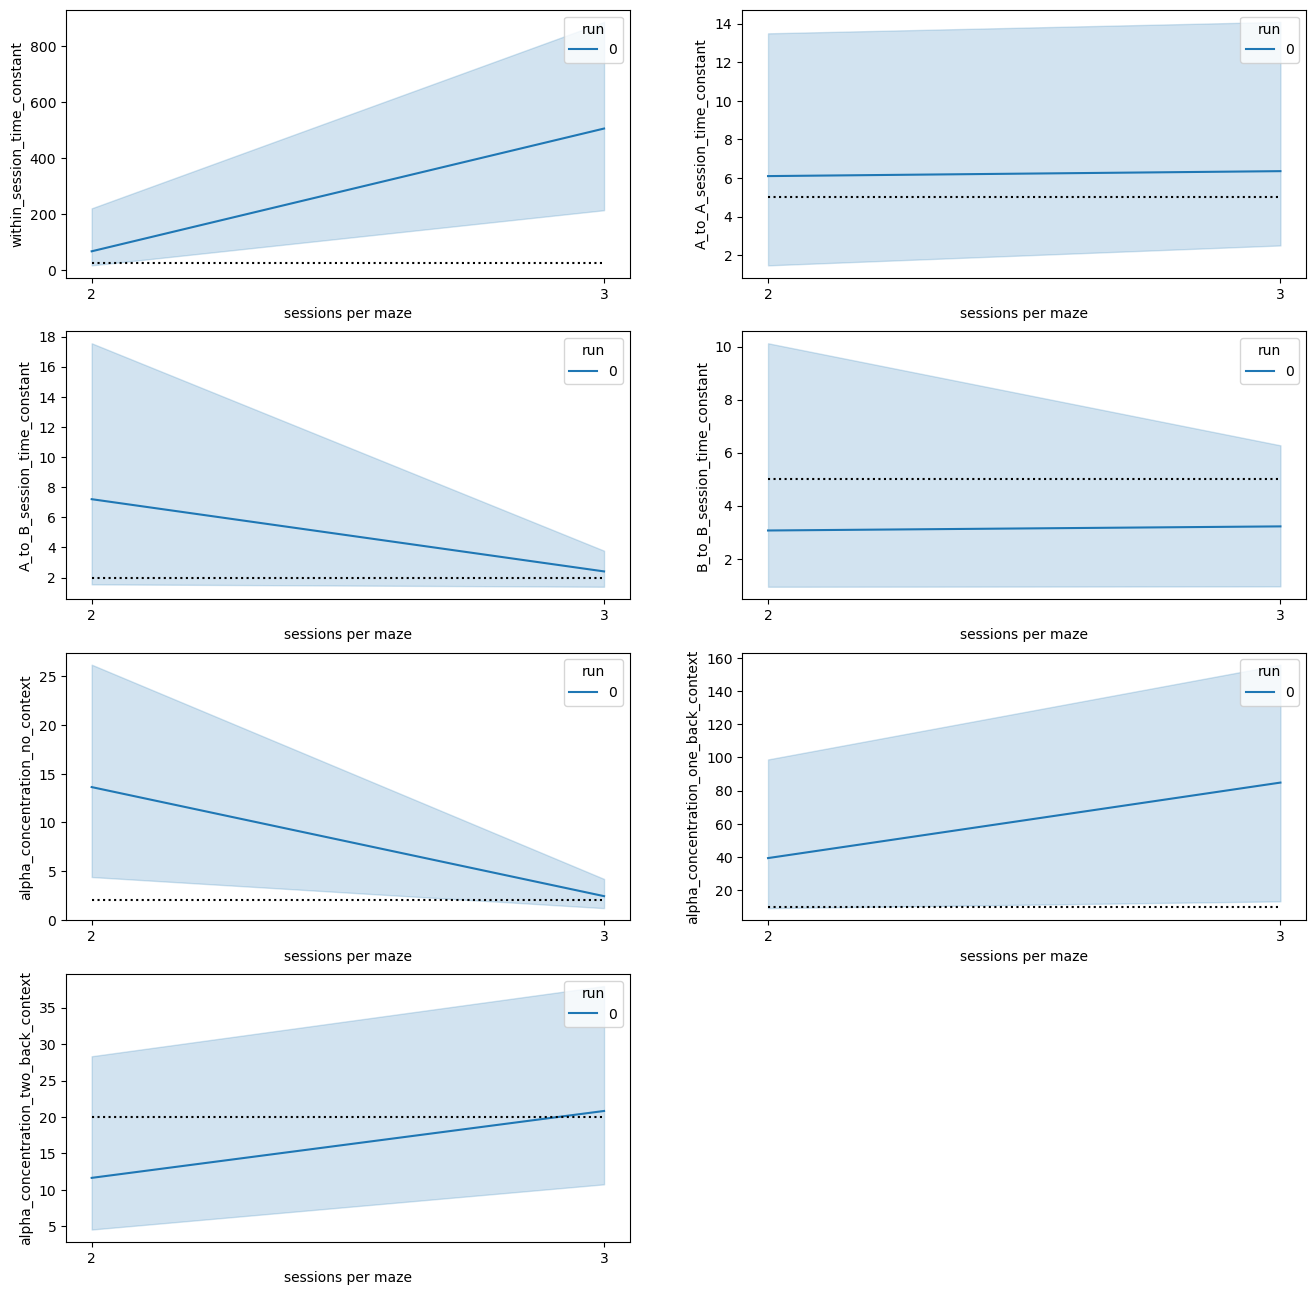

In [11]:
parameters_s = parameters.stack([1,2]).reset_index()    
n_cols = 2
n_rows = int(np.ceil(len(true_parameters)/float(n_cols)))
plt.figure(figsize=(n_cols*8,n_rows*4))

print(len(true_parameters))
for ii, p_name in enumerate(true_parameters.keys()):
    plt.subplot(n_rows, n_cols, ii+1)
    # for each parameter in the data frame, make a plot of 95% CI and mean over time vs. true params
    pp = sns.lineplot(x="sessions per maze", y=p_name,
                hue="run", errorbar=("pi",95),
                data=parameters_s)
    plt.plot([2,max_blocks_per_type], [true_parameters[p_name], true_parameters[p_name]], "k:")
    pp.set_xticks(range(2,max_blocks_per_type+1))

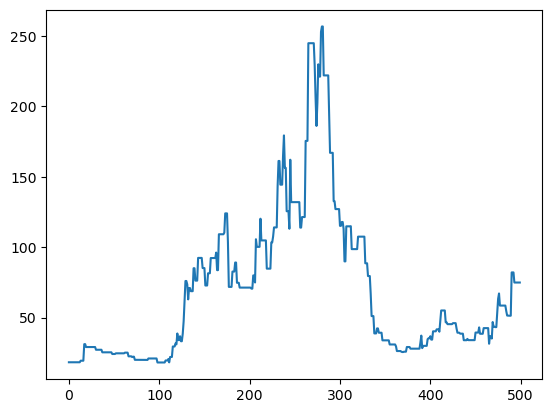

In [13]:
plt.plot(np.array(parameters["within_session_time_constant"][2][0]))